# Handwritten Character Recognition

This notebook demonstrates the process of building and training a handwritten character recognition system using PyTorch. It covers data loading and augmentation, defining several Convolutional Neural Network (CNN) models (including custom architectures and transfer learning with VGG19), training these models, and finally, performing inference on single images.

In [1]:
# General utilities
import os
import random

# Image processing and display
import matplotlib.pyplot as plt
from PIL import Image
import cv2 # OpenCV for image operations
import numpy as np

# PyTorch essentials
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
# Device configuration
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# In a Jupyter Notebook, multiprocessing start method handling is less critical 
# than in standalone scripts, especially if not using num_workers > 0 in DataLoader
# or if issues arise. If needed, it can be set.
# try:
#     torch.multiprocessing.set_start_method('spawn', force=True)
#     print("Set multiprocessing start method to 'spawn'.")
# except RuntimeError as e:
#     print(f"Note: {e}. Multiprocessing start method might have been already set.")

Using device: mps


### Custom Data Augmentation Transforms

The following cells define custom PyTorch transforms used for data augmentation. `RandomChoice` applies one randomly selected transform from a list, and `ThicknessTransform` simulates variations in stroke thickness.

In [3]:
class RandomChoice(torch.nn.Module):
    """Apply one randomly chosen transform from a list of transforms.
    Args:
        transforms (list of callable): List of transforms to choose from.
    """
    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms

    def __call__(self, img):
        return random.choice(self.transforms)(img)

class ThicknessTransform(torch.nn.Module):
    """Apply morphological operations to change stroke thickness.
    It randomly chooses between dilation (thicker) or erosion (thinner).
    Args:
        kernel_size (int): Size of the kernel for morphological operations (default: 3).
        iterations (int): Number of times to apply the operation (default: 1).
    """
    def __init__(self, kernel_size=3, iterations=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.iterations = iterations

    def __call__(self, img):
        # Convert PIL Image to OpenCV format (numpy array)
        img_cv = np.array(img)
        
        # Ensure image is grayscale for morphological operations
        if len(img_cv.shape) == 3 and img_cv.shape[2] == 3:
            img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
        elif len(img_cv.shape) == 3 and img_cv.shape[2] == 1: # Already grayscale but 3-channel
             img_cv = img_cv[:, :, 0]
        
        kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)
        
        if random.random() > 0.5:
            # Dilation (thicker)
            processed_img = cv2.dilate(img_cv, kernel, iterations=self.iterations)
        else:
            # Erosion (thinner)
            processed_img = cv2.erode(img_cv, kernel, iterations=self.iterations)
        
        # Convert back to PIL Image
        return Image.fromarray(processed_img, mode='L') # 'L' for grayscale

### Handwriting Data Pipeline

The `HandwritingDataPipeline` class manages the loading, augmentation, and splitting of the image dataset. 

Key features:
- **Purpose**: Encapsulates all data handling steps, from reading images from disk to preparing them in batches for training, validation, and testing.
- **Parameters**:
    - `data_root`: The root directory where the dataset is stored. Images should be organized into subdirectories, where each subdirectory name corresponds to a class label (e.g., 'A', 'B', '0', '1').
    - `image_size`: The target size (height, width) to which all images will be resized.
    - `batch_size`: The number of images per batch for the DataLoaders.
    - `do_transform`: A boolean flag to enable or disable data augmentation. Augmentation is typically enabled for the training set to improve model generalization.
- **Data Split**: The pipeline splits the dataset into training, validation, and test sets (typically 70%/15%/15% split). This is crucial for evaluating the model's performance on unseen data and for hyperparameter tuning.
- **Normalization**: Image pixel values are normalized (mean and standard deviation) based on ImageNet statistics, which is a common practice, especially when using pretrained models. For grayscale images, the mean and std are often applied across all three channels if the pretrained model expects 3-channel input.

In [4]:
class HandwritingDataPipeline:
    def __init__(self, data_root, image_size=(64, 64), batch_size=32, do_transform=True, test_split=0.15, val_split=0.15):
        self.data_root = data_root
        self.image_size = image_size
        self.batch_size = batch_size
        self.do_transform = do_transform
        self.test_split = test_split
        self.val_split = val_split # Val split is from the remaining data after test_split

        # Normalization parameters (ImageNet defaults, suitable for transfer learning)
        # For grayscale, these are often applied as (mean, mean, mean) and (std, std, std)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])

        self._setup_transforms()
        self._load_and_split_datasets()

    def _setup_transforms(self):
        if self.do_transform:
            self.train_transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.Grayscale(num_output_channels=1), # Ensure grayscale
                RandomChoice([
                    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
                    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
                ]),
                ThicknessTransform(kernel_size=random.choice([1,3]), iterations=random.choice([1,2])),
                transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3), # Still useful for grayscale
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # Repeat grayscale channel for models expecting 3 channels
                self.normalize
            ])
        else:
            self.train_transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
                self.normalize
            ])

        self.val_test_transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
            self.normalize
        ])

    def _load_and_split_datasets(self):
        full_dataset = datasets.ImageFolder(root=self.data_root)
        self.class_names = full_dataset.classes
        self.num_classes = len(self.class_names)

        total_size = len(full_dataset)
        test_size = int(total_size * self.test_split)
        remaining_size = total_size - test_size
        val_size = int(remaining_size * (self.val_split / (1.0 - self.test_split))) # val_split is a fraction of the original total
        train_size = remaining_size - val_size

        # Check if sizes are valid
        if train_size <= 0 or val_size <=0 or test_size <=0:
            print(f"Warning: Dataset too small for current split ratios. Total: {total_size}")
            # Fallback to simpler split if calculated sizes are problematic
            if total_size < 3:
                train_set, val_set, test_set = full_dataset, full_dataset, full_dataset # Use all for all if tiny
            else:
                # Simplified split for small datasets
                train_size = max(1, int(total_size * 0.7))
                val_size = max(1, int(total_size * 0.15))
                test_size = total_size - train_size - val_size
                if test_size <= 0: # Ensure test_size is at least 1 if possible
                    test_size = 1
                    val_size = total_size - train_size - test_size
                    if val_size <=0:
                        val_size = 1
                        train_size = total_size - val_size - test_size
                
        print(f"Attempting to split: Train={train_size}, Val={val_size}, Test={test_size}")
        try:
            train_temp_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size + val_size, test_size],
                                                                          generator=torch.Generator().manual_seed(42))
            train_dataset, val_dataset = torch.utils.data.random_split(train_temp_dataset, [train_size, val_size],
                                                                       generator=torch.Generator().manual_seed(42))
        except Exception as e:
            print(f"Error during dataset splitting: {e}. Adjusting split sizes or check dataset.")
            # Fallback: if split fails, assign datasets to avoid crashing, though this is not ideal.
            # This might happen if dataset is extremely small. User should be warned.
            print("Using full dataset for train/val/test due to splitting error. THIS IS NOT RECOMMENDED FOR ACTUAL TRAINING.")
            train_dataset, val_dataset, test_dataset = full_dataset, full_dataset, full_dataset

        # Assign transforms
        # We need to wrap these datasets to apply transforms
        self.train_dataset = TransformedDataset(train_dataset, transform=self.train_transform)
        self.val_dataset = TransformedDataset(val_dataset, transform=self.val_test_transform)
        self.test_dataset = TransformedDataset(test_dataset, transform=self.val_test_transform)
        
        self.sizes = {'train': len(self.train_dataset), 'val': len(self.val_dataset), 'test': len(self.test_dataset)}

    def get_loaders(self, shuffle_train=True, shuffle_val=False, shuffle_test=False):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=shuffle_train, num_workers=0) # num_workers=0 for notebooks generally safer
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=shuffle_val, num_workers=0)
        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=shuffle_test, num_workers=0)
        return train_loader, val_loader, test_loader

    def get_class_labels(self):
        return self.class_names

# Helper class to apply transforms to subsets from random_split
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [5]:
# Data Pipeline Initialization and Loader Retrieval Example

# IMPORTANT: Replace this path with the actual path to your dataset's root folder.
# The dataset should be structured with subfolders for each class (e.g., data_root/A, data_root/B, ...).
data_root_example = "./content/augmented_images/augmented_images1" # <<< USER: CHANGE THIS PATH

print(f"Attempting to initialize data pipeline with root: {data_root_example}")
print("If this path is incorrect or the dataset is not structured as expected (ImageFolder format), this cell will error.")

# Check if the placeholder path exists, if not, this cell will likely error later but we can warn now.
if not os.path.exists(data_root_example):
    print(f"\nWARNING: The directory '{data_root_example}' does not exist. \nPlease ensure your dataset is available at this path or update 'data_root_example'.")
    print("Skipping pipeline initialization and loader retrieval for now as the path is invalid.")
    # Assign None to loaders to prevent subsequent cells from crashing immediately if they use these variables
    # Users will need to fix the path and re-run for those cells to work.
    train_loader_example, val_loader_example, test_loader_example, dataset_sizes_example, num_classes_example = None, None, None, None, None
    example_pipeline = None
else:
    try:
        example_pipeline = HandwritingDataPipeline(data_root=data_root_example, image_size=(64,64), batch_size=16, do_transform=True)
        train_loader_example, val_loader_example, test_loader_example = example_pipeline.get_loaders()
        dataset_sizes_example = example_pipeline.sizes
        num_classes_example = example_pipeline.num_classes

        print(f"\nData pipeline initialized successfully.")
        print(f"Dataset split sizes: {dataset_sizes_example}")
        print(f"Number of classes: {num_classes_example}")
        print(f"Class labels: {example_pipeline.get_class_labels()}")
        print(f"Train loader: {train_loader_example}, Val loader: {val_loader_example}, Test loader: {test_loader_example}")
    except Exception as e:
        print(f"\nERROR initializing data pipeline or getting loaders: {e}")
        print("Please check the 'data_root_example' path and the dataset structure.")
        train_loader_example, val_loader_example, test_loader_example, dataset_sizes_example, num_classes_example = None, None, None, None, None
        example_pipeline = None

# Note to user:
# For the subsequent cells (like displaying augmented images or training models) to run,
# the 'data_root_example' path must be correctly set and the dataset must be present and structured correctly.

Attempting to initialize data pipeline with root: ./content/augmented_images/augmented_images1
If this path is incorrect or the dataset is not structured as expected (ImageFolder format), this cell will error.
Attempting to split: Train=9548, Val=2046, Test=2046

Data pipeline initialized successfully.
Dataset split sizes: {'train': 9548, 'val': 2046, 'test': 2046}
Number of classes: 62
Class labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_caps', 'B_caps', 'C_caps', 'D_caps', 'E_caps', 'F_caps', 'G_caps', 'H_caps', 'I_caps', 'J_caps', 'K_caps', 'L_caps', 'M_caps', 'N_caps', 'O_caps', 'P_caps', 'Q_caps', 'R_caps', 'S_caps', 'T_caps', 'U_caps', 'V_caps', 'W_caps', 'X_caps', 'Y_caps', 'Z_caps', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train loader: <torch.utils.data.dataloader.DataLoader object at 0x31703bd50>, Val loader: <torch.utils.data.dataloader.DataLoader object at 0x316140950>, T

### Display Augmented Images

This function helps visualize the effect of the data augmentation techniques applied to the training images. It fetches a batch of images from the training loader and displays a few of them, each with multiple augmented versions.

Displaying augmented images... Note: 'Base' and 'Aug' may look similar if augmentation is subtle or loader doesn't re-augment per call as expected.


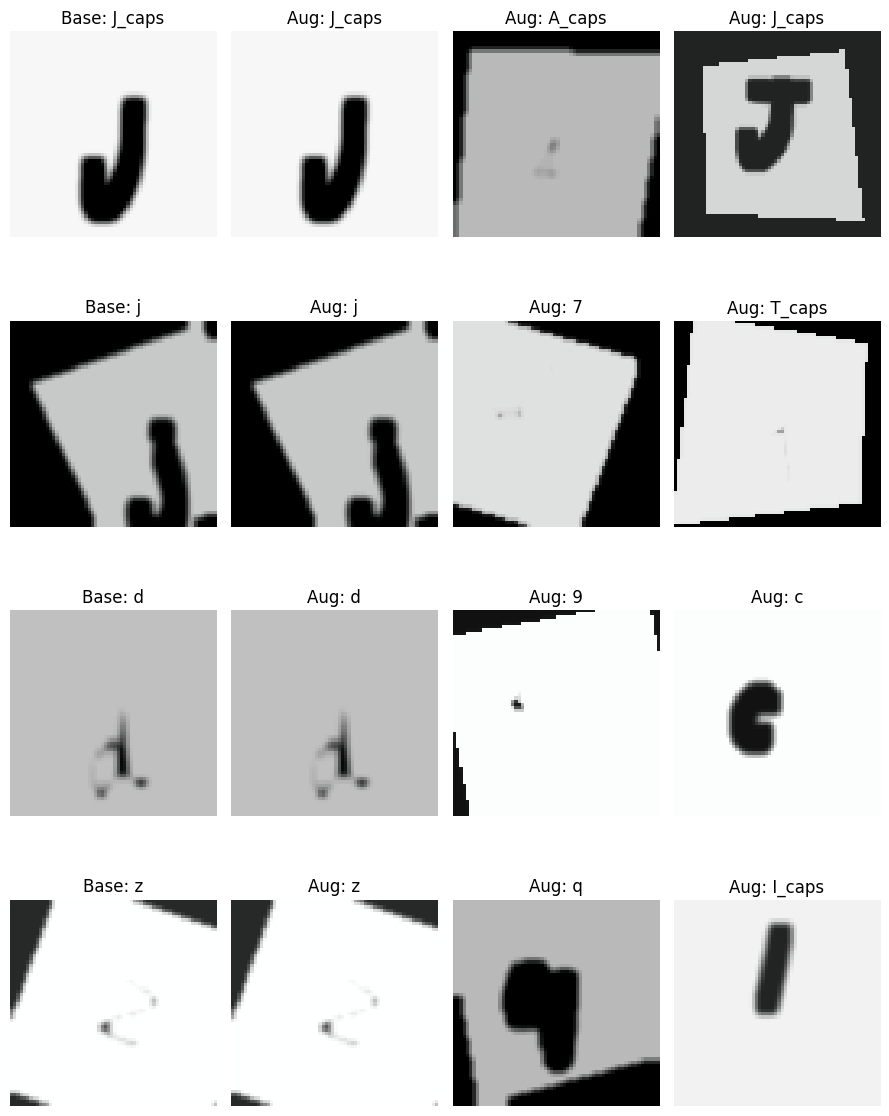

In [6]:
def display_augmented_images(data_loader, class_names, num_images=5, num_augmentations=3):
    """Displays original and augmented images from the train_loader.
    Args:
        data_loader (DataLoader): The DataLoader for the training set.
        class_names (list): List of class names.
        num_images (int): Number of unique images to display.
        num_augmentations (int): Number of augmented versions to show per image (if using augmentation in loader).
                                 If loader doesn't re-augment on each call, this will show similar images.
                                 For this notebook, it will show different augmentations if the loader is set up with diverse transforms.
    """
    if data_loader is None:
        print("Data loader is None. Cannot display images. Please ensure the data pipeline was initialized correctly.")
        return
    
    plt.figure(figsize=(num_augmentations * 3, num_images * 3))
    
    # Temporarily set a batch size for display if needed, or rely on loader's batch size
    # This function assumes the loader can provide at least num_images
    try:
        images_so_far = 0
        for i in range(num_augmentations):
            # Get a batch of images. Iterating the loader will give new batches (potentially augmented differently)
            try:
                inputs, classes = next(iter(data_loader))
            except StopIteration:
                print("Could not fetch a new batch from data_loader. Maybe dataset is too small or loader exhausted?")
                return
            
            # Ensure we have enough images in the batch
            if len(inputs) < num_images and i == 0:
                print(f"Warning: Batch size ({len(inputs)}) is less than num_images ({num_images}). Displaying available images.")
                # num_images = len(inputs) # this would change plotting layout, better to inform user

            for j in range(min(num_images, len(inputs))): # Iterate up to num_images or available images in batch
                if i == 0: # For the first set of augmentations, also store original-like images
                    ax = plt.subplot(num_images, num_augmentations + 1, j * (num_augmentations + 1) + 1)
                    ax.set_title(f"Base: {class_names[classes[j]]}")
                    img = inputs[j].numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean # Unnormalize
                    img = np.clip(img, 0, 1)
                    plt.imshow(img)
                    plt.axis('off')
                
                ax = plt.subplot(num_images, num_augmentations + 1, j * (num_augmentations + 1) + i + 2)
                ax.set_title(f"Aug: {class_names[classes[j]]}")
                img = inputs[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean # Unnormalize
                img = np.clip(img, 0, 1)
                plt.imshow(img)
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not display images: {e}. Ensure train_loader is valid and contains data.")

# Example usage (ensure train_loader_example and example_pipeline are valid from the previous cell)
if train_loader_example and example_pipeline:
    print("Displaying augmented images... Note: 'Base' and 'Aug' may look similar if augmentation is subtle or loader doesn't re-augment per call as expected.")
    display_augmented_images(train_loader_example, class_names=example_pipeline.get_class_labels(), num_images=4, num_augmentations=3)
else:
    print("Skipping display_augmented_images example as train_loader_example or example_pipeline is not available. Please fix the data path.")

### Model Definitions: Custom CNNs

Below are definitions for two custom Convolutional Neural Network (CNN) architectures:
- `LetterCNN64`: A basic CNN model designed for 64x64 pixel input images.
- `ImprovedLetterCNN`: An enhanced version of `LetterCNN64` that incorporates Batch Normalization for stable training and Dropout for regularization to prevent overfitting.

In [ ]:
class LetterCNN64(nn.Module):
    def __init__(self, num_classes):
        super(LetterCNN64, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input 3 channels (RGB-like after transform)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input size: 64x64 -> After conv1 (padding=1): 64x64 -> After pool1: 32x32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input size: 32x32 -> After conv2 (padding=1): 32x32 -> After pool2: 16x16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input size: 16x16 -> After conv3 (padding=1): 16x16 -> After pool3: 8x8
        
        # Fully connected layers
        # Flattened size: 128 channels * 8 * 8 = 8192
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8) # Flatten the tensor
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

class ImprovedLetterCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedLetterCNN, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64x64 -> 32x32

        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32x32 -> 16x16

        # Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 16x16 -> 8x8

        # Layer 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 8x8 -> 4x4

        # Fully connected layers
        # Flattened size: 256 channels * 4 * 4 = 4096
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5) # Dropout for regularization

        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Conv blocks
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 256 * 4 * 4)
        
        # FC layers
        x = self.dropout1(self.relu_fc1(self.bn_fc1(self.fc1(x))))
        x = self.dropout2(self.relu_fc2(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)
        return x

### Model Definition: VGG19 Transfer Learning

This section defines `VGG19HandwritingModel`, which leverages a pre-trained VGG19 model for transfer learning. 
- **Transfer Learning**: Instead of training a model from scratch, we use the VGG19 architecture with weights pre-trained on the large ImageNet dataset. These learned features are often effective for various computer vision tasks.
- **Adaptation for Grayscale**: The first convolutional layer of VGG19 is modified to accept single-channel (grayscale) input images, as our handwriting dataset is primarily grayscale. The weights of this layer can be initialized by averaging the original weights across the three color channels or by other strategies.
- **Custom Classifier**: The original VGG19 classifier (fully connected layers) is replaced with a new classifier suited to the number of classes in our handwriting dataset. This new classifier will be trained on our specific task.

In [ ]:
class VGG19HandwritingModel(nn.Module):
    def __init__(self, num_classes, device, pretrained=True):
        super(VGG19HandwritingModel, self).__init__()
        self.device = device
        # Load a pretrained VGG19 model
        vgg19 = models.vgg19_bn(weights=models.VGG19_BN_Weights.IMAGENET1K_V1 if pretrained else None)

        # Modify the first convolutional layer to accept 1 input channel (grayscale)
        # instead of 3 (RGB). We do this by averaging the weights of the original first conv layer.
        original_first_conv = vgg19.features[0]
        new_first_conv = nn.Conv2d(1, original_first_conv.out_channels, 
                                     kernel_size=original_first_conv.kernel_size, 
                                     stride=original_first_conv.stride, 
                                     padding=original_first_conv.padding,
                                     dilation=original_first_conv.dilation,
                                     groups=original_first_conv.groups,
                                     bias=(original_first_conv.bias is not None))
        
        if pretrained:
            # Average the weights across the input channels (RGB) for the new grayscale channel
            new_first_conv.weight.data = torch.mean(original_first_conv.weight.data, dim=1, keepdim=True)
            if original_first_conv.bias is not None:
                new_first_conv.bias.data = original_first_conv.bias.data
        
        # Replace the first conv layer in the features module
        vgg19.features[0] = new_first_conv
        
        # The input transformation pipeline already converts grayscale to 3-channel pseudo-RGB
        # to match VGG's original expectation. So, direct modification of vgg19.features[0] to take 1 channel
        # is an alternative if we change the ToTensor() + normalize pipeline to output 1 channel directly.
        # For this notebook, we assume the DataPipeline prepares 3-channel images (by repeating grayscale).
        # Thus, we will use the original VGG first layer that expects 3 channels.
        # If we strictly wanted to use the modified single-channel input VGG, the data pipeline's Lambda
        # that repeats channels should be removed and this model's first layer should be the `new_first_conv` for 1 channel.
        # For simplicity and consistency with common transfer learning where input channels are matched, 
        # we will stick to the 3-channel input for VGG provided by the data pipeline.
        # THEREFORE, the above modification to new_first_conv is more of a demonstration.
        # We will use the standard VGG first layer expecting 3 channels, as our pipeline provides that.
        # If data pipeline was changed to output 1 channel, then the modified layer would be essential.
        # Let's revert to the original vgg19 features if the pipeline provides 3 channels.
        # For this notebook, the pipeline's transforms.Lambda(lambda x: x.repeat(3,1,1)) ensures 3 channels.
        # So, no change to VGG's first layer is strictly necessary here if that lambda is used.
        # However, if one *wanted* to feed 1-channel images directly, they'd uncomment the above and modify the pipeline.
        # For clarity, let's use the standard VGG expecting 3 channels as per the pipeline.
        
        # Re-load VGG19 but this time we are sure our pipeline gives 3 channels.
        vgg19 = models.vgg19_bn(weights=models.VGG19_BN_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = vgg19.features

        # Freeze feature parameters if using pretrained model (common practice for transfer learning)
        if pretrained:
            for param in self.features.parameters():
                param.requires_grad = False
        
        # Replace the classifier with a new one appropriate for num_classes
        # VGG19's classifier input features: 512 * 7 * 7 (if input is 224x224)
        # Since our input is 64x64, the output feature map size from self.features will be different.
        # VGG19 with 64x64 input: after 5 maxpools (64 -> 32 -> 16 -> 8 -> 4 -> 2)
        # So, the output from features will be (batch_size, 512, 2, 2)
        num_features_output = 512 * 2 * 2 
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features_output, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        # The data pipeline ensures x is (batch, 3, H, W)
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

### Core Utility Functions: Training, Loading, and Testing

These functions are essential for the model development lifecycle:
- `train_model`: Handles the training loop, including forward pass, loss calculation, backpropagation, optimizer steps, and learning rate scheduling. It also includes logic for validating the model periodically and saving the best performing model checkpoint as well as the final model.
- `load_model`: Utility to load saved model checkpoints (weights and optimizer state) to resume training or for inference.
- `test_model`: Evaluates the trained model on the test dataset to assess its generalization performance on unseen data, reporting accuracy and loss.

In [ ]:
import time
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, save_dir='model_checkpoints'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")
        
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    
    # Store history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            if dataloader is None or len(dataloader.dataset) == 0:
                print(f"Skipping {phase} phase as dataloader is None or dataset is empty.")
                if phase == 'val' and best_acc == 0: # if val loader is bad, cannot determine best model based on val_acc
                     # Save model based on training performance or just save last if no val set
                     pass # Or consider other metrics if val is unavailable
                continue

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
            
            if total_samples == 0: # Avoid division by zero if dataset was empty
                epoch_loss = 0
                epoch_acc = 0
                print(f"No samples found for {phase} phase in epoch {epoch+1}.")
            else:
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item()) # .item() to get Python number
            else: # phase == 'val'
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if scheduler:
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(epoch_loss)
                    # For other schedulers like CosineAnnealingLR, step is usually called after optimizer.step()
                    # For this structure, it's fine here if not ReduceLROnPlateau
                    elif phase == 'train' and scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                         pass # Handled below after optimizer step for most schedulers

                if epoch_acc > best_acc and total_samples > 0 : # ensure val set was processed
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch + 1
                    # Save best model checkpoint
                    best_model_path = os.path.join(save_dir, 'best_model.pth')
                    torch.save({
                        'epoch': best_epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': epoch_loss,
                        'accuracy': best_acc.item(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None
                    }, best_model_path)
                    print(f"Best model saved to {best_model_path} (Epoch {best_epoch}, Val Acc: {best_acc:.4f})")
        
        if phase == 'train' and scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step() # Step for schedulers like CosineAnnealing, StepLR etc.
        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f} at epoch {best_epoch}')

    # Load best model weights back
    if best_acc > 0: # only load if a best model was found (i.e. val phase ran)
        model.load_state_dict(best_model_wts)
    
    # Save final model
    final_model_path = os.path.join(save_dir, 'final_model.pth')
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': history['val_loss'][-1] if history['val_loss'] else history['train_loss'][-1],
        'accuracy': history['val_acc'][-1] if history['val_acc'] else history['train_acc'][-1],
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    return model, history

def load_model(model, optimizer, checkpoint_path, scheduler=None):
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint path {checkpoint_path} does not exist. Returning initial model.")
        return model, optimizer, scheduler, 0, 0.0, 0.0

    checkpoint = torch.load(checkpoint_path, map_location=device) # map_location ensures tensors are loaded to the correct device
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state only if optimizer is provided and state exists in checkpoint
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        except ValueError as e:
            print(f"Warning: Could not load optimizer state: {e}. Optimizer will be reinitialized.")
    
    # Load scheduler state only if scheduler is provided and state exists in checkpoint
    if scheduler is not None and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        except Exception as e: # Catching general exception as state loading can have various issues
            print(f"Warning: Could not load scheduler state: {e}. Scheduler may be reinitialized or use default state.")
            
    start_epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', 0.0)
    accuracy = checkpoint.get('accuracy', 0.0)
    
    print(f"Model loaded from {checkpoint_path}. Epoch: {start_epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    return model, optimizer, scheduler, start_epoch, loss, accuracy

def test_model(model, test_loader, criterion=None):
    if test_loader is None or len(test_loader.dataset) == 0:
        print("Test loader is None or dataset is empty. Skipping testing.")
        return 0.0, 0.0
        
    model.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss() # Default criterion if not provided

    with torch.no_grad(): # No need to track gradients during testing
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    if total_samples == 0:
        print("No samples found in the test set.")
        return 0.0, 0.0
        
    test_loss = running_loss / total_samples
    test_acc = running_corrects.double() / total_samples

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    return test_loss, test_acc.item()

## Experiment 1: Training a Custom CNN (`ImprovedLetterCNN`)

In this experiment, we will train the `ImprovedLetterCNN` model defined earlier. This model includes improvements like Batch Normalization and Dropout. We will use data augmentation during training.

In [ ]:
# --- Experiment 1: Training ImprovedLetterCNN ---
print("--- Experiment 1: Training ImprovedLetterCNN ---")

# Ensure data_root_example and device are defined from earlier cells.
# If example_pipeline was successfully initialized, we can use its properties.
if example_pipeline is not None and num_classes_example is not None:
    save_dir_cnn = 'model_checkpoints_cnn'
    if not os.path.exists(save_dir_cnn):
        os.makedirs(save_dir_cnn)

    # Re-initialize pipeline for this experiment if needed, or use existing one
    # For clarity, let's assume we might want different settings, so re-init or use specific vars
    # This assumes data_root_example is correctly set by the user.
    print(f"Using data_root: {data_root_example} for CNN experiment.")
    cnn_pipeline = HandwritingDataPipeline(data_root=data_root_example, image_size=(64,64), batch_size=32, do_transform=True)
    train_loader_cnn, val_loader_cnn, test_loader_cnn = cnn_pipeline.get_loaders()
    num_classes_cnn = cnn_pipeline.num_classes
    
    if num_classes_cnn > 0 and len(train_loader_cnn.dataset) > 0:
        print(f"Number of classes for CNN: {num_classes_cnn}")
        print(f"Train samples: {len(train_loader_cnn.dataset)}, Val samples: {len(val_loader_cnn.dataset)}, Test samples: {len(test_loader_cnn.dataset)}")

        model_cnn = ImprovedLetterCNN(num_classes_cnn).to(device)
        criterion_cnn = nn.CrossEntropyLoss()

        # Optimizer and Scheduler Setup
        optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.0005) # Adjusted LR from 0.001 to 0.0005
        scheduler_cnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.1, patience=3, verbose=True)

        # --- Other Scheduler Examples (commented out) ---
        # scheduler_cnn_step = torch.optim.lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)
        # # Note: For StepLR, T_max and eta_min are not applicable. StepLR reduces LR by gamma every step_size epochs.

        # scheduler_cnn_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn, T_max=20, eta_min=1e-6) # T_max = num_epochs
        # # Note: CosineAnnealingLR gradually decreases LR following a cosine curve.

        # num_epochs_cnn = 20 # Define num_epochs if using schedulers that require it like OneCycleLR or CosineAnnealingLR
        # scheduler_cnn_onecycle = torch.optim.lr_scheduler.OneCycleLR(optimizer_cnn, max_lr=0.001, epochs=num_epochs_cnn, steps_per_epoch=len(train_loader_cnn))
        # # Note: OneCycleLR varies LR, increasing then decreasing it over the epochs. max_lr should typically be determined with an LR range test.
        # --- End of Other Scheduler Examples ---

        num_epochs_cnn_train = 20 # Set number of epochs for this experiment
        print(f"Starting training for ImprovedLetterCNN for {num_epochs_cnn_train} epochs...")
        
        # Train the model
        trained_model_cnn, history_cnn = train_model(model_cnn, train_loader_cnn, val_loader_cnn, 
                                                   criterion_cnn, optimizer_cnn, scheduler_cnn, 
                                                   num_epochs=num_epochs_cnn_train, save_dir=save_dir_cnn)
        
        print("\nTesting the final trained ImprovedLetterCNN model on the test set:")
        test_model(trained_model_cnn, test_loader_cnn, criterion_cnn)

        print("\nLoading the best saved ImprovedLetterCNN model and testing it on the test set:")
        # Initialize a new model instance for loading
        best_model_cnn_instance = ImprovedLetterCNN(num_classes_cnn).to(device)
        # Create a dummy optimizer for load_model function, its state will be overwritten if saved in checkpoint
        # Or, if you need to resume training with this optimizer, re-initialize it as before.
        dummy_optimizer_cnn = optim.Adam(best_model_cnn_instance.parameters()) 
        best_cnn_model_loaded, _, _, _, _, _ = load_model(best_model_cnn_instance, 
                                                       dummy_optimizer_cnn, 
                                                       os.path.join(save_dir_cnn, 'best_model.pth'))
        test_model(best_cnn_model_loaded, test_loader_cnn, criterion_cnn)
    else:
        print("Skipping Experiment 1: CNN training, due to invalid number of classes or empty train loader.")
        print(f"  Number of classes: {num_classes_cnn if 'num_classes_cnn' in locals() else 'Not determined'}")
        print(f"  Train loader dataset length: {len(train_loader_cnn.dataset) if 'train_loader_cnn' in locals() and hasattr(train_loader_cnn, 'dataset') else 'Not determined'}")
else:
    print("Skipping Experiment 1: CNN training, as the data pipeline was not initialized successfully in the earlier cell.")
    print("Please ensure 'data_root_example' is set correctly and the dataset is accessible.")

## Experiment 2: Training with Transfer Learning (`VGG19HandwritingModel`)

This experiment explores transfer learning using the `VGG19HandwritingModel`. We will initialize the model with weights pre-trained on ImageNet and fine-tune it on our handwriting dataset. We will also demonstrate how to set up the optimizer with different learning rates for the pre-trained feature extractor and the newly initialized classifier.

In [ ]:
# --- Experiment 2: Training VGG19HandwritingModel ---
print("--- Experiment 2: Training VGG19HandwritingModel ---")

if example_pipeline is not None and num_classes_example is not None:
    save_dir_vgg = 'model_checkpoints_vgg'
    if not os.path.exists(save_dir_vgg):
        os.makedirs(save_dir_vgg)

    print(f"Using data_root: {data_root_example} for VGG experiment.")
    # It's good practice to have a separate pipeline instance if batch_size or other params differ
    # Or re-use cnn_pipeline if settings are identical
    vgg_pipeline = HandwritingDataPipeline(data_root=data_root_example, image_size=(64,64), batch_size=32, do_transform=True)
    train_loader_vgg, val_loader_vgg, test_loader_vgg = vgg_pipeline.get_loaders()
    num_classes_vgg = vgg_pipeline.num_classes
    num_epochs_vgg = 20 # Define number of epochs for VGG training

    if num_classes_vgg > 0 and len(train_loader_vgg.dataset) > 0:
        print(f"Number of classes for VGG: {num_classes_vgg}")
        print(f"Train samples: {len(train_loader_vgg.dataset)}, Val samples: {len(val_loader_vgg.dataset)}, Test samples: {len(test_loader_vgg.dataset)}")

        # Model Initialization
        # Option 1: Use pretrained VGG19
        use_pretrained_vgg = True # Set to False to train VGG from scratch
        model_vgg = VGG19HandwritingModel(num_classes=num_classes_vgg, device=device, pretrained=use_pretrained_vgg).to(device)
        print(f"VGG19 Model initialized {'with pretrained ImageNet weights' if use_pretrained_vgg else 'from scratch'}.")

        criterion_vgg = nn.CrossEntropyLoss()

        # Optimizer and Scheduler Setup for VGG
        if use_pretrained_vgg:
            # Different learning rates for feature extractor (lower LR) and classifier (higher LR)
            optimizer_vgg = optim.Adam([
                {'params': model_vgg.features.parameters(), 'lr': 1e-5}, # Lower LR for frozen or slowly unfrozen features
                {'params': model_vgg.classifier.parameters(), 'lr': 1e-4} # Higher LR for the new classifier part
            ], weight_decay=1e-4) # Added weight decay
            # Scheduler for fine-tuning pretrained model
            scheduler_vgg = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vgg, T_max=num_epochs_vgg, eta_min=1e-6)
            print("Optimizer set up for pretrained VGG model with differential learning rates.")
        else:
            # Training VGG from scratch (typically requires more epochs and careful LR tuning)
            optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=1e-3, weight_decay=1e-4)
            # OneCycleLR is often good for training from scratch
            scheduler_vgg = torch.optim.lr_scheduler.OneCycleLR(optimizer_vgg, 
                                                                max_lr=1e-3, 
                                                                epochs=num_epochs_vgg, 
                                                                steps_per_epoch=len(train_loader_vgg))
            print("Optimizer set up for VGG model training from scratch.")

        print(f"Starting training for VGG19HandwritingModel for {num_epochs_vgg} epochs...")
        trained_model_vgg, history_vgg = train_model(model_vgg, train_loader_vgg, val_loader_vgg, 
                                                   criterion_vgg, optimizer_vgg, scheduler_vgg, 
                                                   num_epochs=num_epochs_vgg, save_dir=save_dir_vgg)

        print("\nTesting the final trained VGG19 model on the test set:")
        test_model(trained_model_vgg, test_loader_vgg, criterion_vgg)

        print("\nLoading the best saved VGG19 model and testing it on the test set:")
        best_model_vgg_instance = VGG19HandwritingModel(num_classes=num_classes_vgg, device=device, pretrained=False).to(device) # `pretrained` here only affects init, weights are loaded next
        dummy_optimizer_vgg = optim.Adam(best_model_vgg_instance.parameters())
        best_vgg_model_loaded, _, _, _, _, _ = load_model(best_model_vgg_instance, 
                                                       dummy_optimizer_vgg, 
                                                       os.path.join(save_dir_vgg, 'best_model.pth'))
        test_model(best_vgg_model_loaded, test_loader_vgg, criterion_vgg)
    else:
        print("Skipping Experiment 2: VGG training, due to invalid number of classes or empty train loader.")
        print(f"  Number of classes: {num_classes_vgg if 'num_classes_vgg' in locals() else 'Not determined'}")
        print(f"  Train loader dataset length: {len(train_loader_vgg.dataset) if 'train_loader_vgg' in locals() and hasattr(train_loader_vgg, 'dataset') else 'Not determined'}")
else:
    print("Skipping Experiment 2: VGG training, as the data pipeline was not initialized successfully.")
    print("Please ensure 'data_root_example' is set correctly and the dataset is accessible.")

## Inference on a Single Image

This section shows how to load a trained model (either the custom CNN or the VGG model) and use it to predict the character from a single image. You'll need to provide the path to your trained model and the image you want to classify.

In [ ]:
def get_class_labels(data_root):
    """Gets class labels from the folder names in data_root."""
    if not os.path.exists(data_root):
        print(f"Error: Data root directory '{data_root}' not found for getting class labels.")
        return []
    # Assuming ImageFolder structure where subdirectories are class names
    try:
        dataset = datasets.ImageFolder(root=data_root)
        return dataset.classes
    except Exception as e:
        print(f"Error loading dataset from '{data_root}' to get class labels: {e}")
        return []

In [ ]:
def prepare_image(image_path, image_size=(64, 64)):
    """Loads an image, converts to grayscale, resizes, and prepares it for model inference."""
    if not os.path.exists(image_path):
        print(f"Error: Image path '{image_path}' not found.")
        return None
    try:
        img = Image.open(image_path).convert('L') # Convert to grayscale
        
        # Define transformations similar to validation/test transform but without dataset context
        # Normalization values should be consistent with training
        normalize_inference = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])
        
        inference_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(), # This will convert grayscale PIL image (H,W) to (1,H,W) tensor
            transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # Repeat for 3 channels
            normalize_inference
        ])
        
        img_tensor = inference_transform(img)
        return img_tensor.unsqueeze(0) # Add batch dimension -> (1, 3, H, W)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [ ]:
# --- Perform Inference --- 
print("--- Inference Section ---")

# USER ACTION REQUIRED:
# 1. Set `inference_model_path` to the path of your trained model checkpoint (e.g., best_model.pth from CNN or VGG experiment).
# 2. Set `data_root_for_labels` to the *same data_root* used during training to ensure class labels are mapped correctly.
# 3. Set `image_path_for_inference` to the path of the image you want to classify.

inference_model_path = os.path.join('model_checkpoints_cnn', 'best_model.pth') # Example: using best CNN model
# Or for VGG: inference_model_path = os.path.join('model_checkpoints_vgg', 'best_model.pth')

data_root_for_labels = data_root_example # Use the same data_root as defined in cell 6 (or your training data path)

# Example image path - replace with your own image.
# You might need to upload an image to your Colab environment or provide a full path if running locally.
# image_path_for_inference = "path/to/your/character/image.png" 
image_path_for_inference = "" # Intentionally blank: USER MUST PROVIDE A PATH

print(f"Using model: {inference_model_path}")
print(f"Using data root for labels: {data_root_for_labels}")

if not os.path.exists(inference_model_path):
    print(f"ERROR: Model checkpoint '{inference_model_path}' not found. Please train a model or provide a valid path.")
elif not image_path_for_inference or not os.path.exists(image_path_for_inference):
    print(f"INFO: 'image_path_for_inference' is not set or the file does not exist ('{image_path_for_inference}').")
    print("Please provide a valid image path to perform inference.")
    # You could create a dummy image here for demonstration if you have cv2/numpy and know the dataset structure
    # For example, to create a dummy 'A.png':
    # if not os.path.exists("example_char.png"):
    #     dummy_img_arr = np.zeros((64,64,1), dtype=np.uint8)
    #     cv2.putText(dummy_img_arr, 'A', (10,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255), 3)
    #     cv2.imwrite("example_char.png", dummy_img_arr)
    #     image_path_for_inference = "example_char.png"
    #     print("Created a dummy 'example_char.png'. Re-run this cell with this path or your own.")
    # else:
    #     image_path_for_inference = "example_char.png"
    #     print(f"Using existing 'example_char.png'. Re-run cell if you want to use your own image.")
else:
    class_labels = get_class_labels(data_root_for_labels)
    if not class_labels:
        print("ERROR: Could not retrieve class labels. Ensure 'data_root_for_labels' is correct.")
    else:
        num_classes_inference = len(class_labels)
        print(f"Number of classes for inference: {num_classes_inference}, Labels: {class_labels}")

        # Initialize the model architecture
        # IMPORTANT: This must match the architecture of the saved model in 'inference_model_path'
        # If loading a VGG model, use: VGG19HandwritingModel(num_classes=num_classes_inference, device=device, pretrained=False).to(device)
        # The `pretrained=False` here is fine because we are loading weights from our checkpoint.
        inference_model_arch = ImprovedLetterCNN(num_classes_inference).to(device) # Assuming CNN model
        # If using VGG, uncomment below and comment out the ImprovedLetterCNN line:
        # inference_model_arch = VGG19HandwritingModel(num_classes=num_classes_inference, device=device, pretrained=False).to(device)
        
        # Create a dummy optimizer for load_model. Its state isn't used if only inferring.
        dummy_optimizer_inference = optim.Adam(inference_model_arch.parameters())

        # Load the trained model weights
        loaded_inference_model, _, _, _, _, _ = load_model(inference_model_arch, 
                                                          dummy_optimizer_inference, 
                                                          inference_model_path)
        loaded_inference_model.eval() # Set model to evaluation mode

        # Prepare the input image
        input_tensor = prepare_image(image_path_for_inference).to(device)

        if input_tensor is not None:
            with torch.no_grad(): # Disable gradient calculations for inference
                outputs = loaded_inference_model(input_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                confidence, predicted_class_idx = torch.max(probabilities, 1)
                
                predicted_label = class_labels[predicted_class_idx.item()]
                confidence_percent = confidence.item() * 100
                
                print(f"\nImage: {image_path_for_inference}")
                print(f"Predicted Class: {predicted_label}")
                print(f"Confidence: {confidence_percent:.2f}%")

                # Display the image (optional)
                try:
                    img_display = Image.open(image_path_for_inference)
                    plt.imshow(img_display)
                    plt.title(f"Predicted: {predicted_label} ({confidence_percent:.2f}%)")
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Could not display the image: {e}")
        else:
            print("Could not prepare image for inference.")

## Conclusion

This notebook provided a comprehensive walkthrough of a handwritten character recognition task using PyTorch. We covered:
- Setting up a data pipeline with image loading, transformations, and augmentations.
- Defining and comparing custom CNN architectures (`LetterCNN64`, `ImprovedLetterCNN`).
- Implementing transfer learning with a pre-trained VGG19 model (`VGG19HandwritingModel`), including modifying it for the specific task.
- Core functions for training, model checkpointing (saving best and final models), loading models, and evaluating them on a test set.
- Running two distinct training experiments: one for the custom `ImprovedLetterCNN` and another for the `VGG19HandwritingModel`.
- A section demonstrating how to perform inference on a single image using a trained model.

This framework can be extended and adapted for various image classification tasks. For further improvements, one could explore more advanced architectures, different augmentation strategies, hyperparameter optimization techniques, or larger datasets.

In [ ]:
# Install Gradio (quietly)
!pip install gradio -q
import gradio as gr
print(f"Gradio version: {gr.__version__}")

## Interactive Demos with Gradio

### Demo 1: Single Character Recognition

In [ ]:
# Ensure class_labels are loaded or defined globally for the notebook if not already
# Example: data_root_for_labels = "./content/augmented_images/augmented_images1" 
# class_labels = get_class_labels(data_root_for_labels)
# num_classes = len(class_labels)

# Placeholder for where models are saved (ensure these paths are correct)
MODEL_PATH_CNN = os.path.join('model_checkpoints_cnn', 'best_model.pth')
MODEL_PATH_VGG = os.path.join('model_checkpoints_vgg', 'best_model.pth') # Assuming VGG model is also saved as best_model.pth in its own dir

def predict_single_character(image_input, model_choice):
    if image_input is None:
        return "No image provided", "0.0%"

    # Image can be PIL from upload or NumPy from Sketchpad
    if isinstance(image_input, np.ndarray):
        # For Sketchpad: input is usually (height, width, 3) or (height, width)
        # Convert to PIL for consistent processing
        if image_input.ndim == 3 and image_input.shape[2] == 3: # RGB from sketchpad
            image_pil = Image.fromarray(image_input, 'RGB').convert('L')
        elif image_input.ndim == 2: # Grayscale from sketchpad (less likely for default sketchpad)
            image_pil = Image.fromarray(image_input, 'L')
        else: 
            image_pil = Image.fromarray(image_input).convert('L')


    elif isinstance(image_input, Image.Image):
        image_pil = image_input.convert('L') # Ensure PIL and grayscale
    else:
        return "Invalid image input", "0.0%"

    # Get class labels (ensure this is defined and accessible)
    # This path might need to be adjusted by the user.
    data_root_for_labels = "./content/augmented_images/augmented_images1" 
    if not os.path.exists(data_root_for_labels):
        return "Error: data_root_for_labels path for class names does not exist. Please check the path in the notebook.", ""
    
    class_labels = get_class_labels(data_root_for_labels)
    if not class_labels: # Handle case where class_labels might be empty
        return "Error: Could not load class labels. Ensure data_root is correct and contains data.", ""
    num_classes = len(class_labels)

    # Preprocess the image
    # The model expects 3 channels after ToTensor and Normalize in the training pipeline
    # For Gradio, we use a Normalize that expects single channel and then repeat it for the model
    # However, the provided training pipeline's normalize expects 3 channels.
    # Let's align with the training pipeline's val_test_transform more closely.
    gradio_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(), # Converts to (1, H, W)
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # Converts to (3, H, W)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Use same normalization as training
    ])
    img_tensor = gradio_transform(image_pil).unsqueeze(0).to(device)

    # Load selected model
    if model_choice == 'ImprovedCNN':
        model_path = MODEL_PATH_CNN
        model = ImprovedLetterCNN(num_classes).to(device)
        if not os.path.exists(model_path): return f"Model checkpoint not found: {model_path}", "0.0%"
    elif model_choice == 'VGG19':
        model_path = MODEL_PATH_VGG
        model = VGG19HandwritingModel(num_classes=num_classes, device=device, pretrained=False).to(device)
        if not os.path.exists(model_path): return f"Model checkpoint not found: {model_path}", "0.0%"
    else:
        return "Invalid model choice", "0.0%"
    
    try:
        checkpoint = torch.load(model_path, map_location=device)
        # Check if the checkpoint contains 'model_state_dict'
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else: # Assume the checkpoint itself is the state_dict (older saving format)
            model.load_state_dict(checkpoint)
        model.eval()
    except Exception as e:
        return f"Error loading model: {str(e)}", "0.0%"

    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_char = class_labels[predicted_idx.item()]
    
    return predicted_char, f"{confidence.item()*100:.2f}%"

iface_single = gr.Interface(
    fn=predict_single_character,
    inputs=[
        gr.Sketchpad(label="Draw a Character Here", type="numpy", image_mode="L", invert_colors=True, shape=(128,128)), # Increased shape for better drawing
        gr.Dropdown(choices=['ImprovedCNN', 'VGG19'], label="Choose Model", value='ImprovedCNN')
    ],
    outputs=[
        gr.Label(label="Prediction"),
        gr.Label(label="Confidence")
    ],
    title="Single Handwritten Character Recognition",
    description="Draw a character (ensure it's centered and reasonably large), then choose a model to predict it. Ensure model checkpoints exist by running training cells first."
)

### Demo 2: Multiple Character Recognition (Word/Sentence)

In [ ]:
def segment_characters(image_pil):
    # Convert PIL image to OpenCV format
    image_np = np.array(image_pil.convert('L')) # Grayscale
    
    # Preprocessing for segmentation: 
    # Input images for segmentation are typically black text on white background.
    # THRESH_BINARY_INV will make the text white (objects) and background black.
    thresh = cv2.adaptiveThreshold(image_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    
    min_h, max_h = 10, image_np.shape[0] * 0.95 
    min_w, max_w = 5, image_np.shape[1] * 0.9  
    aspect_ratio_min, aspect_ratio_max = 0.1, 3.0

    filtered_boxes = []
    for x, y, w, h in bounding_boxes:
        if min_h < h < max_h and min_w < w < max_w:
            aspect_ratio = w / float(h) if h > 0 else 0
            if aspect_ratio_min < aspect_ratio < aspect_ratio_max:
                # Filter out boxes that are likely part of other larger boxes (simple check)
                is_nested = False
                for x2, y2, w2, h2 in bounding_boxes:
                    if (x > x2 and y > y2 and x+w < x2+w2 and y+h < y2+h2) and (w*h < 0.5 * w2*h2):
                        is_nested = True
                        break
                if not is_nested:
                     filtered_boxes.append((x, y, w, h))
            
    bounding_boxes = sorted(filtered_boxes, key=lambda b: b[0])
    
    cropped_characters = []
    img_for_boxes_np = np.array(image_pil.convert('RGB'))

    for x, y, w, h in bounding_boxes:
        # Crop from the original grayscale image_np (black text on white bg)
        char_img_np = image_np[y:y+h, x:x+w]
        
        # Add padding (white background for model input)
        pad_size = int(max(w,h) * 0.20) 
        # Pad with white (255) as model expects black char on white bg before ToTensor
        char_img_np_padded = cv2.copyMakeBorder(char_img_np, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, value=255)
        
        char_img_pil = Image.fromarray(char_img_np_padded).convert('L')
        cropped_characters.append(char_img_pil)
        
        cv2.rectangle(img_for_boxes_np, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    return Image.fromarray(img_for_boxes_np), cropped_characters

In [ ]:
def predict_multiple_characters(image_input, model_choice):
    if image_input is None:
        return None, "No image provided"

    if isinstance(image_input, np.ndarray):
        image_pil = Image.fromarray(image_input).convert('L')
    elif isinstance(image_input, Image.Image):
        image_pil = image_input.convert('L') # Ensure grayscale for segmentation
    else:
        return None, "Invalid image input"

    image_with_boxes, char_images_pil = segment_characters(image_pil)
    
    if not char_images_pil:
        return image_with_boxes, "No characters detected or segmented properly"

    data_root_for_labels = "./content/augmented_images/augmented_images1"
    if not os.path.exists(data_root_for_labels):
        return image_with_boxes, "Error: data_root_for_labels path for class names does not exist."

    class_labels = get_class_labels(data_root_for_labels)
    if not class_labels:
        return image_with_boxes, "Error: Could not load class labels."
    num_classes = len(class_labels)
    
    gradio_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    if model_choice == 'ImprovedCNN':
        model_path = MODEL_PATH_CNN
        model = ImprovedLetterCNN(num_classes).to(device)
        if not os.path.exists(model_path): return image_with_boxes, f"CNN Model checkpoint not found: {model_path}"
    elif model_choice == 'VGG19':
        model_path = MODEL_PATH_VGG
        model = VGG19HandwritingModel(num_classes=num_classes, device=device, pretrained=False).to(device)
        if not os.path.exists(model_path): return image_with_boxes, f"VGG Model checkpoint not found: {model_path}"
    else:
        return image_with_boxes, "Invalid model choice"
    
    try:
        checkpoint = torch.load(model_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        model.eval()
    except Exception as e:
        return image_with_boxes, f"Error loading model: {str(e)}"

    predictions_text = ""
    with torch.no_grad():
        for char_pil in char_images_pil:
            img_tensor = gradio_transform(char_pil).unsqueeze(0).to(device)
            outputs = model(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_char = class_labels[predicted_idx.item()]
            predictions_text += f"{predicted_char} ({confidence.item()*100:.1f}%) "
            
    return image_with_boxes, predictions_text.strip()

iface_multi = gr.Interface(
    fn=predict_multiple_characters,
    inputs=[
        gr.Image(type="pil", label="Upload an Image of a Word/Sentence (black text on white bg recommended for segmentation)"),
        gr.Dropdown(choices=['ImprovedCNN', 'VGG19'], label="Choose Model", value='ImprovedCNN')
    ],
    outputs=[
        gr.Image(label="Detected Characters"),
        gr.Textbox(label="Recognized Text & Confidences", lines=3)
    ],
    title="Multiple Handwritten Character Recognition",
    description="Upload an image containing multiple characters (ideally black text on a light, clean background). The system will attempt to segment and recognize them. Ensure models are trained."
)

In [ ]:
gr.TabbedInterface([iface_single, iface_multi], ["Single Character", "Multiple Characters"]).launch(share=False, debug=True)